In [74]:
import pandas as pd,numpy as np,sklearn
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [75]:
df = pd.read_csv('final_data_used_dec28.csv')
df1 = pd.read_csv('/home/madan/Desktop/joswin_bck/toPendrive/works/chargebee_works/nlp-intelligence/scoring_model/data_used/final_data_crawler_output_jan3.xls')
df1_text = pd.read_csv('/home/madan/Desktop/joswin_bck/toPendrive/works/chargebee_works/nlp-intelligence/scoring_model/data_used/final_data_crawler_output_jan3_all_texts.csv',names=['website','website_text'])

In [85]:
df_left = pd.merge(df,df1,on='website',how='left')
df_not_in_df1 = df_left[pd.isnull(df_left['demo_present_y'])].drop_duplicates('website')

In [86]:
df1 = pd.merge(df1,df1_text)

In [87]:
df1 = pd.merge(df1,df[['website','saas_subscription']])

In [88]:
df1.columns

Index([u'company_linkedin_url', u'demo_present', u'emails', u'id',
       u'login_present', u'match_texts_test', u'pricing_present', u'score',
       u'urls', u'website', u'website_text', u'saas_subscription'],
      dtype='object')

In [90]:
df_not_in_df1.columns

Index([u'website', u'demo_present_x', u'login_present_x', u'pricing_present_x',
       u'score_x', u'website_text', u'saas_subscription',
       u'website_text_phrases', u'website_text_stemmed',
       u'company_linkedin_url', u'demo_present_y', u'emails', u'id',
       u'login_present_y', u'match_texts_test', u'pricing_present_y',
       u'score_y', u'urls'],
      dtype='object')

In [96]:
df_final = pd.concat([df[['website','website_text','saas_subscription']],df1[['website','website_text','saas_subscription']]])
df_final.shape

(1092, 3)

In [104]:
df_final = df_final.drop_duplicates('website')
df_final.shape

(885, 3)

In [98]:
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
snowball_stemmer = SnowballStemmer('english')
def tokenizer(text):
    text = re.sub(' +',' ',re.sub(r'\n|[^a-zA-Z]',' ',text.lower()))
    return [snowball_stemmer.stem(wrd) for wrd in word_tokenize(text) ]
stop_words = stopwords.words()+['http','https','goo','isnt','wwwfacebookcomtr','wwwgoogletagmanagercomnshtml',
                               'and','be','do','facebook','for','in','is','inc','linkedin','of','the','to',
                               'using','use','home','get','us']
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.01,stop_words=stop_words,tokenizer=tokenizer)
tfidf = tfidf_vectorizer.fit_transform(df_final['website_text'].fillna(''))
tfidf.shape

(885, 3848)

In [105]:
df = df_final
tfidf_n_vars = tfidf

In [100]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel,RFE

traing predictions
             precision    recall  f1-score   support

      False       0.91      0.78      0.84       482
       True       0.77      0.91      0.84       403

avg / total       0.85      0.84      0.84       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.81      0.63      0.71       482
       True       0.65      0.82      0.73       403

avg / total       0.74      0.72      0.72       885

46.0


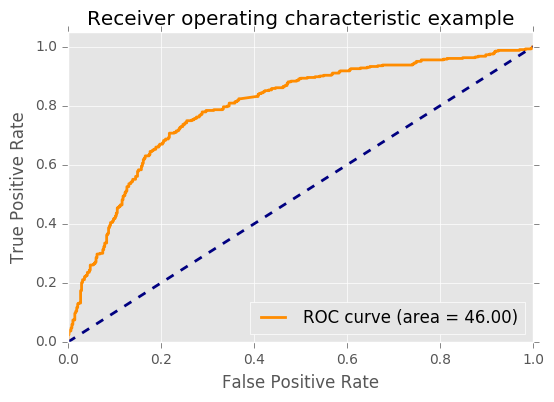

In [106]:
clf = MultinomialNB(fit_prior=False)
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
cv_pred = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10)
print classification_report(df['saas_subscription'],cv_pred)
print auc(df['saas_subscription'],cv_pred)
cv_pred_prob = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10,method='predict_proba')[:,1]
fpr, tpr, _ = roc_curve(df['saas_subscription'], cv_pred_prob)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(df['saas_subscription'],cv_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

traing predictions
             precision    recall  f1-score   support

      False       0.92      0.92      0.92       482
       True       0.91      0.90      0.90       403

avg / total       0.91      0.91      0.91       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.75      0.77      0.76       482
       True       0.72      0.70      0.71       403

avg / total       0.74      0.74      0.74       885

36.5


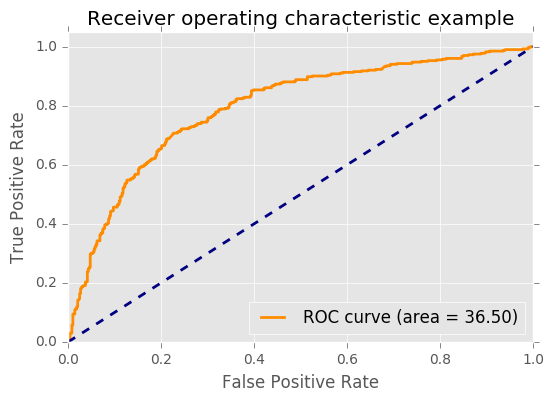

In [109]:
C = 1
clf = SVC(C=C,kernel='linear',probability=True) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
cv_pred = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10)
print classification_report(df['saas_subscription'],cv_pred)
print auc(df['saas_subscription'],cv_pred)
cv_pred_prob = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10,method='predict_proba')[:,1]
fpr, tpr, _ = roc_curve(df['saas_subscription'], cv_pred_prob)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(df['saas_subscription'],cv_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


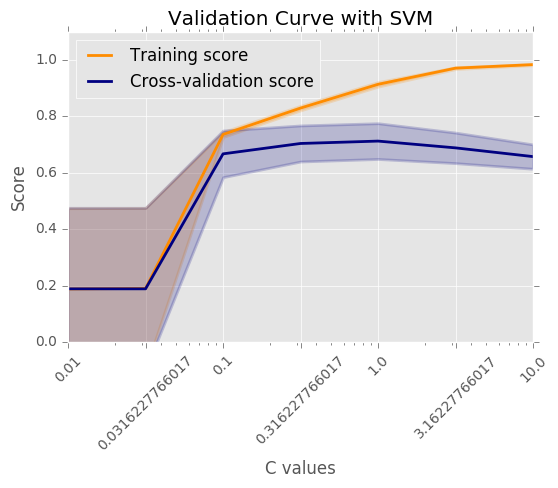

In [108]:
from sklearn.model_selection import validation_curve
param_range = np.logspace(-2, 1, 7)
# param_range = np.arange(1,10,1)
# clf = make_pipeline(StandardScaler(with_mean=False),SVC(C=C,kernel='linear'))
#                     tfidf_n_vars,df['saas_subscription']
train_scores, test_scores = validation_curve(
    SVC(kernel='linear',class_weight='balanced'), tfidf_n_vars,
    df['saas_subscription'], param_name="C", param_range=param_range,
    cv=10, scoring="f1", n_jobs=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("C values")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)

# plt.plot(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.plot(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)

#plotting the actual points(not working)
# for xy in zip(param_range, train_scores_mean):                                       
#     plt.annotate('{}'.format(round(x,5)),xy=xy, textcoords='data') 
# for xy in zip(param_range, test_scores_mean):                                       
#     plt.annotate('{}'.format(round(x,5)),xy=xy, textcoords='data') 

plt.xticks(param_range, param_range,rotation=45)
plt.legend(loc="best")
plt.show()

In [68]:
np.arange(1,10,1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

### plotting learning curves

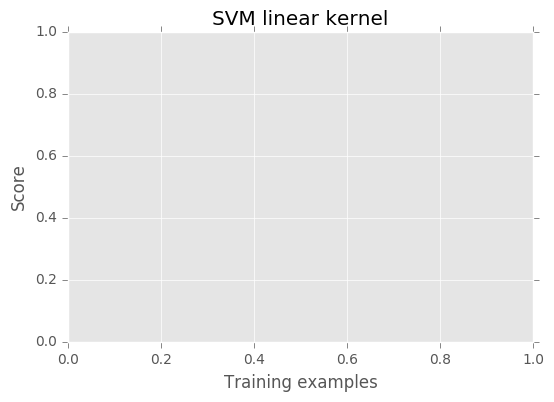

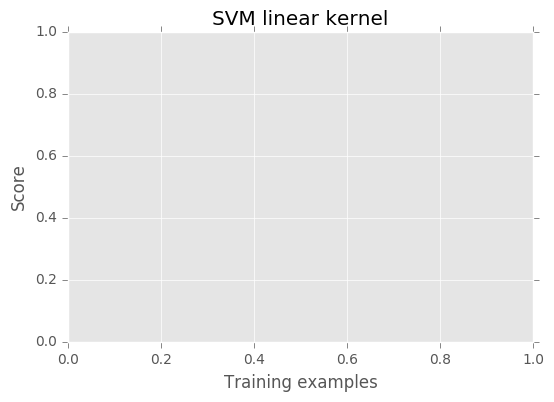

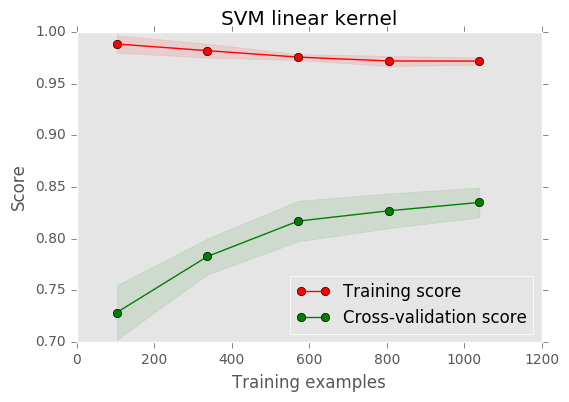

In [73]:
from learning_curves import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
title = "Learning Curves (SVM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C = 2,kernel='linear')
# plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)
plot_learning_curve(estimator=estimator,
                         title='SVM linear kernel',X=tfidf_n_vars,y=df['saas_subscription'],cv=cv)

plt.show()